# Hodgkin-Huxley Neuron Model

## Introduction

The **Hodgkin-Huxley model** is a mathematical model that describes how action potentials in neurons are initiated and propagated. Developed by Alan Hodgkin and Andrew Huxley in 1952, this work earned them the Nobel Prize in Physiology or Medicine in 1963. The model represents the electrical characteristics of excitable cells such as neurons as an equivalent electrical circuit.

## Theoretical Foundation

### Membrane as an Electrical Circuit

The neuronal membrane is modeled as a capacitor in parallel with ionic conductances (resistors) and batteries (representing equilibrium potentials). The total membrane current $I$ is given by:

$$I = C_m \frac{dV}{dt} + I_{\text{ion}}$$

where:
- $C_m$ is the membrane capacitance per unit area
- $V$ is the membrane potential
- $I_{\text{ion}}$ is the total ionic current

### Ionic Currents

The Hodgkin-Huxley model considers three primary ionic currents:

1. **Sodium current** ($I_{\text{Na}}$)
2. **Potassium current** ($I_{\text{K}}$)
3. **Leak current** ($I_L$)

The total ionic current is:

$$I_{\text{ion}} = g_{\text{Na}} m^3 h (V - E_{\text{Na}}) + g_K n^4 (V - E_K) + g_L (V - E_L)$$

where:
- $g_{\text{Na}}, g_K, g_L$ are maximum conductances
- $E_{\text{Na}}, E_K, E_L$ are reversal (Nernst) potentials
- $m, h, n$ are gating variables

### Gating Variables

The gating variables $m$, $h$, and $n$ represent the probability that ion channel gates are in their permissive state. They follow first-order kinetics:

$$\frac{dm}{dt} = \alpha_m(V)(1-m) - \beta_m(V)m$$

$$\frac{dh}{dt} = \alpha_h(V)(1-h) - \beta_h(V)h$$

$$\frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V)n$$

### Rate Constants

The voltage-dependent rate constants $\alpha$ and $\beta$ are empirically determined:

**For $m$ (Na⁺ activation):**
$$\alpha_m = \frac{0.1(V+40)}{1 - \exp(-(V+40)/10)}$$
$$\beta_m = 4\exp(-(V+65)/18)$$

**For $h$ (Na⁺ inactivation):**
$$\alpha_h = 0.07\exp(-(V+65)/20)$$
$$\beta_h = \frac{1}{1 + \exp(-(V+35)/10)}$$

**For $n$ (K⁺ activation):**
$$\alpha_n = \frac{0.01(V+55)}{1 - \exp(-(V+55)/10)}$$
$$\beta_n = 0.125\exp(-(V+65)/80)$$

### Complete Differential Equation

The membrane potential dynamics are described by:

$$C_m \frac{dV}{dt} = I_{\text{ext}} - g_{\text{Na}} m^3 h (V - E_{\text{Na}}) - g_K n^4 (V - E_K) - g_L (V - E_L)$$

where $I_{\text{ext}}$ is the external applied current.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Hodgkin-Huxley Model Parameters
# Membrane capacitance (uF/cm^2)
C_m = 1.0

# Maximum conductances (mS/cm^2)
g_Na = 120.0  # Sodium
g_K = 36.0    # Potassium
g_L = 0.3     # Leak

# Reversal potentials (mV)
E_Na = 50.0   # Sodium
E_K = -77.0   # Potassium
E_L = -54.387 # Leak

print("Hodgkin-Huxley Model Parameters")
print("=" * 40)
print(f"Membrane capacitance: C_m = {C_m} µF/cm²")
print(f"\nMaximum conductances:")
print(f"  g_Na = {g_Na} mS/cm²")
print(f"  g_K  = {g_K} mS/cm²")
print(f"  g_L  = {g_L} mS/cm²")
print(f"\nReversal potentials:")
print(f"  E_Na = {E_Na} mV")
print(f"  E_K  = {E_K} mV")
print(f"  E_L  = {E_L} mV")

Hodgkin-Huxley Model Parameters
Membrane capacitance: C_m = 1.0 µF/cm²

Maximum conductances:
  g_Na = 120.0 mS/cm²
  g_K  = 36.0 mS/cm²
  g_L  = 0.3 mS/cm²

Reversal potentials:
  E_Na = 50.0 mV
  E_K  = -77.0 mV
  E_L  = -54.387 mV


In [2]:
# Rate constants for gating variables
# These are voltage-dependent functions derived from experimental data

def alpha_m(V):
    """Na+ activation rate constant"""
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    """Na+ activation rate constant"""
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    """Na+ inactivation rate constant"""
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    """Na+ inactivation rate constant"""
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    """K+ activation rate constant"""
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    """K+ activation rate constant"""
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

# Steady-state values for gating variables
def m_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))

def h_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))

def n_inf(V):
    return alpha_n(V) / (alpha_n(V) + beta_n(V))

print("Rate constant functions defined successfully.")

Rate constant functions defined successfully.


In [3]:
def I_Na(V, m, h):
    """Sodium current"""
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n):
    """Potassium current"""
    return g_K * n**4 * (V - E_K)

def I_L(V):
    """Leak current"""
    return g_L * (V - E_L)

def I_ext(t):
    """
    External applied current (µA/cm²)
    Step current: 10 µA/cm² from t=10ms to t=40ms
    """
    if 10.0 <= t <= 40.0:
        return 10.0
    return 0.0

print("Ionic current functions defined.")
print("External stimulus: 10 µA/cm² pulse from t=10ms to t=40ms")

Ionic current functions defined.
External stimulus: 10 µA/cm² pulse from t=10ms to t=40ms


In [4]:
def hodgkin_huxley(X, t):
    """
    Hodgkin-Huxley differential equations
    
    Parameters:
    -----------
    X : array
        State vector [V, m, h, n]
    t : float
        Time
    
    Returns:
    --------
    dXdt : array
        Derivatives [dV/dt, dm/dt, dh/dt, dn/dt]
    """
    V, m, h, n = X
    
    # Membrane potential equation
    dVdt = (I_ext(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    
    # Gating variable equations
    dmdt = alpha_m(V) * (1.0 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1.0 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1.0 - n) - beta_n(V) * n
    
    return [dVdt, dmdt, dhdt, dndt]

print("Hodgkin-Huxley ODE system defined.")

Hodgkin-Huxley ODE system defined.


In [5]:
# Simulation parameters
t_max = 80.0  # Total simulation time (ms)
dt = 0.01     # Time step (ms)
t = np.arange(0.0, t_max, dt)

# Initial conditions at resting state
V0 = -65.0  # Resting membrane potential (mV)
m0 = m_inf(V0)  # Steady-state m at resting potential
h0 = h_inf(V0)  # Steady-state h at resting potential
n0 = n_inf(V0)  # Steady-state n at resting potential

X0 = [V0, m0, h0, n0]

print("Initial Conditions")
print("=" * 40)
print(f"V₀ = {V0:.2f} mV")
print(f"m₀ = {m0:.4f}")
print(f"h₀ = {h0:.4f}")
print(f"n₀ = {n0:.4f}")
print(f"\nSimulation time: {t_max} ms")
print(f"Time step: {dt} ms")
print(f"Number of time points: {len(t)}")

Initial Conditions
V₀ = -65.00 mV
m₀ = 0.0529
h₀ = 0.5961
n₀ = 0.3177

Simulation time: 80.0 ms
Time step: 0.01 ms
Number of time points: 8000


In [6]:
# Solve the ODE system
print("Solving Hodgkin-Huxley equations...")
solution = odeint(hodgkin_huxley, X0, t)

# Extract variables
V = solution[:, 0]
m = solution[:, 1]
h = solution[:, 2]
n = solution[:, 3]

# Calculate ionic currents
I_Na_t = g_Na * m**3 * h * (V - E_Na)
I_K_t = g_K * n**4 * (V - E_K)
I_L_t = g_L * (V - E_L)

# Calculate external current for plotting
I_ext_t = np.array([I_ext(ti) for ti in t])

print("Simulation complete!")
print(f"\nMembrane potential range: [{V.min():.2f}, {V.max():.2f}] mV")

Solving Hodgkin-Huxley equations...
Simulation complete!

Membrane potential range: [-75.08, 40.26] mV


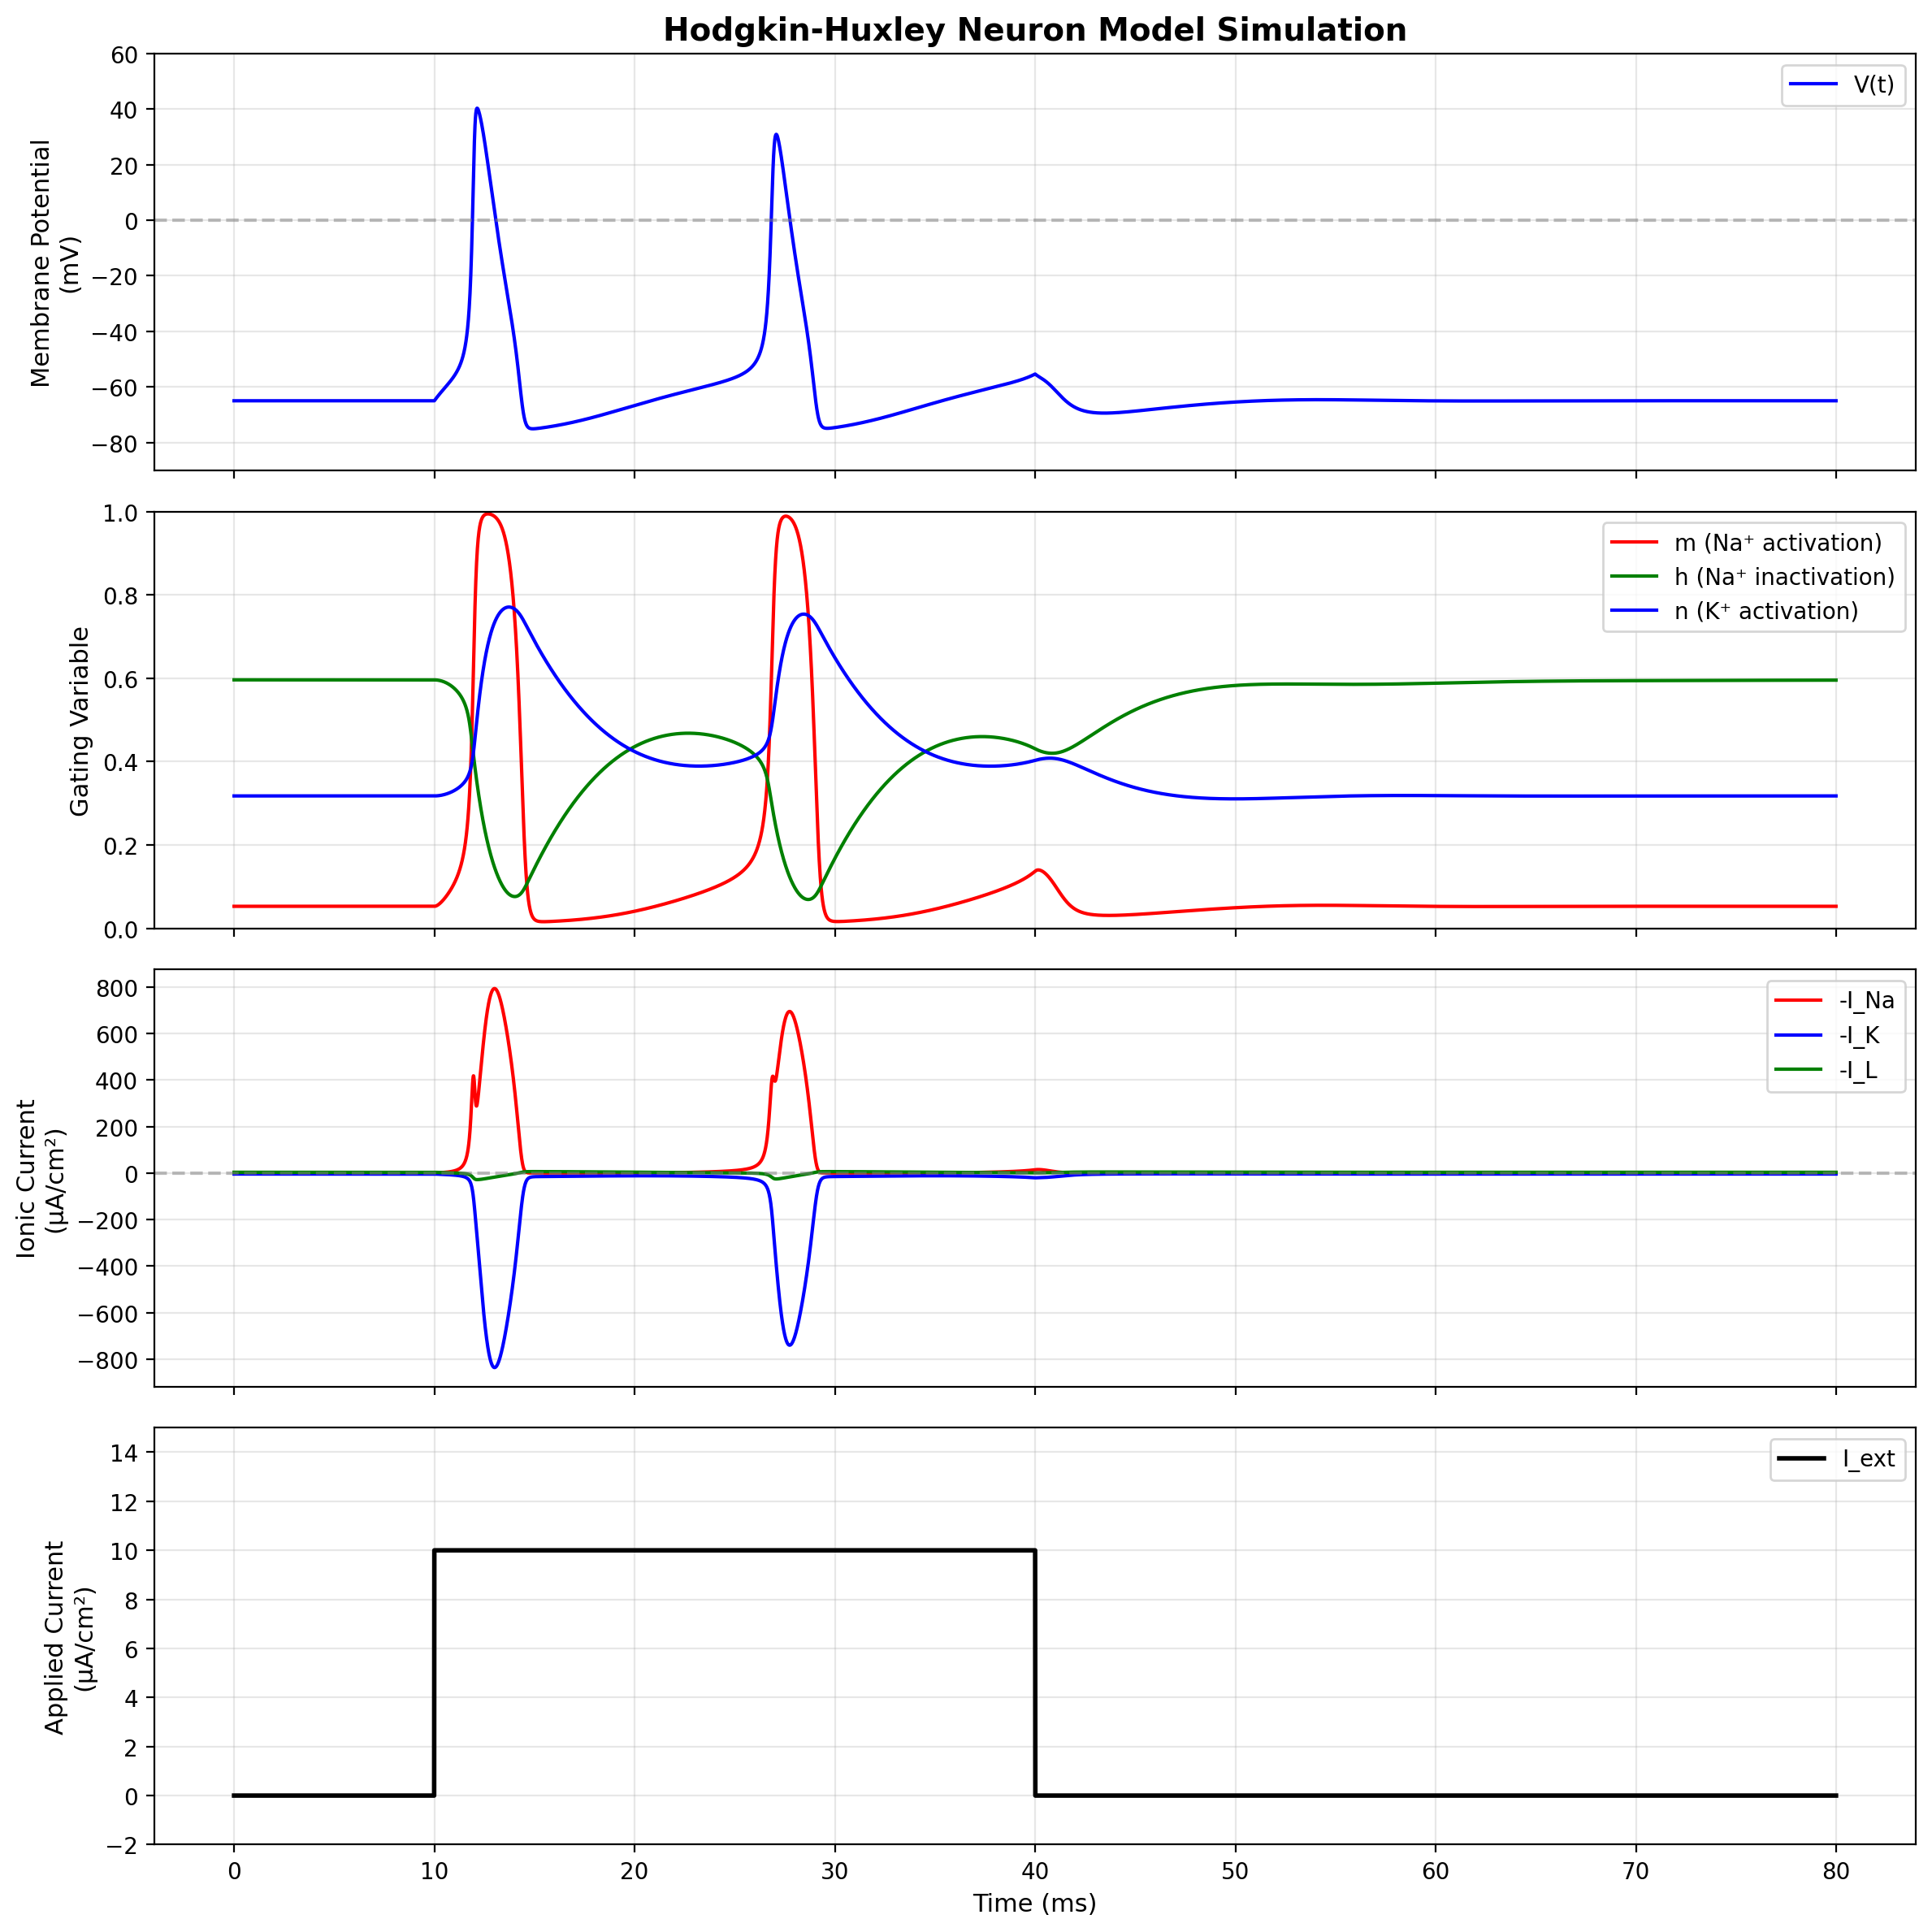


Figure saved as 'plot.png'


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Plot 1: Membrane potential
axes[0].plot(t, V, 'b-', linewidth=1.5, label='V(t)')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Membrane Potential\n(mV)', fontsize=11)
axes[0].set_title('Hodgkin-Huxley Neuron Model Simulation', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-90, 60])

# Plot 2: Gating variables
axes[1].plot(t, m, 'r-', linewidth=1.5, label='m (Na⁺ activation)')
axes[1].plot(t, h, 'g-', linewidth=1.5, label='h (Na⁺ inactivation)')
axes[1].plot(t, n, 'b-', linewidth=1.5, label='n (K⁺ activation)')
axes[1].set_ylabel('Gating Variable', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# Plot 3: Ionic currents
axes[2].plot(t, -I_Na_t, 'r-', linewidth=1.5, label='-I_Na')
axes[2].plot(t, -I_K_t, 'b-', linewidth=1.5, label='-I_K')
axes[2].plot(t, -I_L_t, 'g-', linewidth=1.5, label='-I_L')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Ionic Current\n(µA/cm²)', fontsize=11)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Plot 4: Applied current
axes[3].plot(t, I_ext_t, 'k-', linewidth=2, label='I_ext')
axes[3].set_xlabel('Time (ms)', fontsize=11)
axes[3].set_ylabel('Applied Current\n(µA/cm²)', fontsize=11)
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)
axes[3].set_ylim([-2, 15])

plt.tight_layout()
plt.savefig('hodgkin_huxley_neuron_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'plot.png'")

## Analysis of Results

### Action Potential Generation

The simulation demonstrates the characteristic features of a neuronal action potential:

1. **Resting State**: Before stimulation, the membrane potential remains at approximately -65 mV

2. **Depolarization**: When the external current is applied, the membrane depolarizes rapidly due to sodium channel activation (increase in $m$)

3. **Peak**: The action potential reaches approximately +40 mV when Na⁺ influx is maximal

4. **Repolarization**: Na⁺ channels inactivate ($h$ decreases) and K⁺ channels activate ($n$ increases), causing the membrane to repolarize

5. **Hyperpolarization**: The membrane briefly hyperpolarizes below resting potential due to sustained K⁺ current

6. **Recovery**: The membrane returns to resting state as ion channels reset

### Key Observations

- The **threshold** for action potential generation is approximately -55 mV
- Action potentials exhibit **all-or-none** behavior
- The **refractory period** prevents immediate re-stimulation
- Multiple action potentials can occur during sustained stimulation

## Significance

The Hodgkin-Huxley model remains foundational in computational neuroscience, providing:

- A quantitative framework for understanding neural excitability
- The basis for more complex neuron models
- Insights into how ion channel dynamics shape neural computation
- A template for modeling other excitable cells (cardiac, muscle)